In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import cv2
import gym
import gnwrapper
from tqdm.auto import tqdm
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, GlobalAveragePooling2D, Permute, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

In [3]:
ENV_NAME = 'Pong-v0'
WINDOW_LENGTH = 4
INPUT_SHAPE = (160, 160)

In [4]:
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [5]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        #observation = cv2.resize(observation, INPUT_SHAPE)
        #processed_observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [6]:
input_shape=(WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Conv2D(32, (8, 8), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(64, (4, 4), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute (Permute)            (None, 160, 160, 4)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 153, 153, 32)      8224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 76, 76, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0

In [7]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr='eps',
    value_max=1.,
    value_min=.1,
    value_test=.05,
    nb_steps=1000000
)
dqn = DQNAgent(
    model=model, 
    nb_actions=nb_actions,
    memory=memory,
    policy=policy,
    processor = AtariProcessor(),
    nb_steps_warmup=50000,
    target_model_update=10000,
    train_interval=4
)
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

In [8]:
%%time
dqn.fit(env, nb_steps=175000, visualize=False, verbose=2)

Training for 175000 steps ...


/usr/local/bin/python/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   1260/175000: episode: 1, duration: 20.095s, episode steps: 1260, steps per second:  63, episode reward: -19.000, mean reward: -0.015 [-1.000,  1.000], mean action: 2.444 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   2436/175000: episode: 2, duration: 6.174s, episode steps: 1176, steps per second: 190, episode reward: -21.000, mean reward: -0.018 [-1.000,  0.000], mean action: 2.384 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   3667/175000: episode: 3, duration: 6.374s, episode steps: 1231, steps per second: 193, episode reward: -20.000, mean reward: -0.016 [-1.000,  1.000], mean action: 2.480 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   4800/175000: episode: 4, duration: 5.885s, episode steps: 1133, steps per second: 193, episode reward: -21.000, mean reward: -0.019 [-1.000,  0.000], mean action: 2.487 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   6091/175000: episode: 5, duration: 6.693s, episode steps: 1291, 

  44440/175000: episode: 37, duration: 5.992s, episode steps: 1168, steps per second: 195, episode reward: -20.000, mean reward: -0.017 [-1.000,  1.000], mean action: 2.409 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  45566/175000: episode: 38, duration: 5.866s, episode steps: 1126, steps per second: 192, episode reward: -21.000, mean reward: -0.019 [-1.000,  0.000], mean action: 2.395 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  46863/175000: episode: 39, duration: 6.770s, episode steps: 1297, steps per second: 192, episode reward: -19.000, mean reward: -0.015 [-1.000,  1.000], mean action: 2.343 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  48005/175000: episode: 40, duration: 5.935s, episode steps: 1142, steps per second: 192, episode reward: -20.000, mean reward: -0.018 [-1.000,  1.000], mean action: 2.368 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  49360/175000: episode: 41, duration: 6.919s, episode steps: 13

/usr/local/bin/python/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  50470/175000: episode: 42, duration: 87.361s, episode steps: 1110, steps per second:  13, episode reward: -21.000, mean reward: -0.019 [-1.000,  0.000], mean action: 2.476 [0.000, 5.000],  loss: 0.011216, mae: 0.117274, mean_q: 0.183859, mean_eps: 0.954788
  51832/175000: episode: 43, duration: 73.480s, episode steps: 1362, steps per second:  19, episode reward: -20.000, mean reward: -0.015 [-1.000,  1.000], mean action: 2.468 [0.000, 5.000],  loss: 0.009063, mae: 0.124221, mean_q: 0.180612, mean_eps: 0.953965
  52973/175000: episode: 44, duration: 62.662s, episode steps: 1141, steps per second:  18, episode reward: -21.000, mean reward: -0.018 [-1.000,  0.000], mean action: 2.499 [0.000, 5.000],  loss: 0.009931, mae: 0.125876, mean_q: 0.173087, mean_eps: 0.952838
  54288/175000: episode: 45, duration: 72.008s, episode steps: 1315, steps per second:  18, episode reward: -21.000, mean reward: -0.016 [-1.000,  0.000], mean action: 2.560 [0.000, 5.000],  loss: 0.008656, mae: 0.126722, m

  89929/175000: episode: 74, duration: 57.096s, episode steps: 1030, steps per second:  18, episode reward: -21.000, mean reward: -0.020 [-1.000,  0.000], mean action: 2.505 [0.000, 5.000],  loss: 0.008147, mae: 0.096128, mean_q: 0.111478, mean_eps: 0.919527
  91019/175000: episode: 75, duration: 60.373s, episode steps: 1090, steps per second:  18, episode reward: -21.000, mean reward: -0.019 [-1.000,  0.000], mean action: 2.561 [0.000, 5.000],  loss: 0.009326, mae: 0.090593, mean_q: 0.107153, mean_eps: 0.918573
  92108/175000: episode: 76, duration: 60.823s, episode steps: 1089, steps per second:  18, episode reward: -21.000, mean reward: -0.019 [-1.000,  0.000], mean action: 2.481 [0.000, 5.000],  loss: 0.008724, mae: 0.085757, mean_q: 0.100954, mean_eps: 0.917594
  93598/175000: episode: 77, duration: 82.087s, episode steps: 1490, steps per second:  18, episode reward: -19.000, mean reward: -0.013 [-1.000,  1.000], mean action: 2.434 [0.000, 5.000],  loss: 0.009564, mae: 0.084318, m

 129109/175000: episode: 106, duration: 59.435s, episode steps: 1064, steps per second:  18, episode reward: -21.000, mean reward: -0.020 [-1.000,  0.000], mean action: 2.410 [0.000, 5.000],  loss: 0.007996, mae: 0.047372, mean_q: 0.052534, mean_eps: 0.884280
 130147/175000: episode: 107, duration: 57.235s, episode steps: 1038, steps per second:  18, episode reward: -21.000, mean reward: -0.020 [-1.000,  0.000], mean action: 2.566 [0.000, 5.000],  loss: 0.007790, mae: 0.047339, mean_q: 0.054362, mean_eps: 0.883335
 131162/175000: episode: 108, duration: 55.711s, episode steps: 1015, steps per second:  18, episode reward: -21.000, mean reward: -0.021 [-1.000,  0.000], mean action: 2.699 [0.000, 5.000],  loss: 0.009001, mae: 0.042078, mean_q: 0.049796, mean_eps: 0.882411
 132614/175000: episode: 109, duration: 80.146s, episode steps: 1452, steps per second:  18, episode reward: -19.000, mean reward: -0.013 [-1.000,  1.000], mean action: 2.443 [0.000, 5.000],  loss: 0.008829, mae: 0.03761

 167902/175000: episode: 138, duration: 74.414s, episode steps: 1324, steps per second:  18, episode reward: -20.000, mean reward: -0.015 [-1.000,  1.000], mean action: 2.314 [0.000, 5.000],  loss: 0.009476, mae: 0.009116, mean_q: 0.000742, mean_eps: 0.849484
 168912/175000: episode: 139, duration: 55.438s, episode steps: 1010, steps per second:  18, episode reward: -21.000, mean reward: -0.021 [-1.000,  0.000], mean action: 2.770 [0.000, 5.000],  loss: 0.008673, mae: 0.009295, mean_q: -0.000363, mean_eps: 0.848435
 169928/175000: episode: 140, duration: 56.316s, episode steps: 1016, steps per second:  18, episode reward: -21.000, mean reward: -0.021 [-1.000,  0.000], mean action: 2.696 [0.000, 5.000],  loss: 0.007356, mae: 0.007728, mean_q: 0.001165, mean_eps: 0.847524
 170934/175000: episode: 141, duration: 55.322s, episode steps: 1006, steps per second:  18, episode reward: -21.000, mean reward: -0.021 [-1.000,  0.000], mean action: 2.597 [0.000, 5.000],  loss: 0.008397, mae: 0.0102

In [9]:
dqn.save_weights('atari.h5f', overwrite=True)

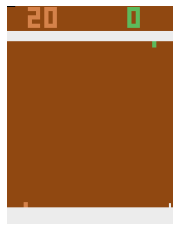

Episode 1: reward: -21.000, steps: 1029


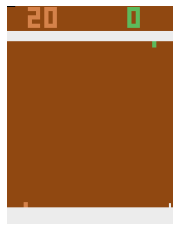

In [11]:
dqn.test(gnwrapper.Animation(env), nb_episodes=1, visualize=True)